In [1]:
from glob import glob
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from anndata import AnnData
from sklearn.neighbors import KDTree
from scipy.stats import spearmanr
from scipy.interpolate import CubicSpline
import scipy

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)
root_path = "/storage/liuyi/00.SNP_project/code/gigascience_update"

/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/anndata/utils.py:429: 

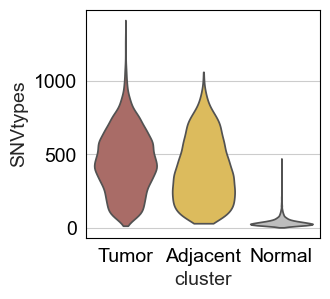

In [2]:
sample = 'CRC-P59-T_1'
rna = sc.read_h5ad(f'{root_path}/rna_adata/{sample}.rna.h5ad')
snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
snv.obs['cluster'] = rna.obs['cluster']
snv.uns['cluster_colors'] = ['#B4635C', '#F1C548', '#BDBDBD']
fig, ax = plt. subplots(figsize=(3,3)) 
sc.pl.violin(snv,['SNVtypes'],groupby='cluster',stripplot=False,show=False,ax = ax )
plt.show()

In [3]:
obsdf = snv.obs[['SNVtypes','cluster']]

In [4]:
from scipy.stats import ttest_ind

data1 = obsdf[obsdf['cluster'] == 'Tumor']['SNVtypes'].tolist()
data2 = obsdf[obsdf['cluster'] == 'Adjacent']['SNVtypes'].tolist()
t_stat, p_value = ttest_ind(data1, data2)
print(p_value)

data1 = obsdf[obsdf['cluster'] == 'Tumor']['SNVtypes'].tolist()
data2 = obsdf[obsdf['cluster'] == 'Normal']['SNVtypes'].tolist()
t_stat, p_value = ttest_ind(data1, data2)
print(p_value)

data1 = obsdf[obsdf['cluster'] == 'Adjacent']['SNVtypes'].tolist()
data2 = obsdf[obsdf['cluster'] == 'Normal']['SNVtypes'].tolist()
t_stat, p_value = ttest_ind(data1, data2)
print(p_value)

2.2377184180054462e-34
0.0
0.0


# fig3c

In [5]:
snv.X = snv.layers['norm']
rna.raw = rna
snv.raw = snv
sc.pp.scale(rna, max_value=10)
sc.pp.scale(snv, max_value=10)

In [6]:
rna.uns['log1p']['base'] =None
snv.uns['log1p'] = {}
snv.uns['log1p']['base'] =None

In [7]:
sc.tl.rank_genes_groups(rna, "cluster", groups=["Adjacent"], reference="Tumor", method="wilcoxon")
sc.tl.rank_genes_groups(snv, "cluster",groups=["Adjacent"], reference="Tumor", method="wilcoxon")

In [8]:
result = rna.uns["rank_genes_groups"]
groups = result["names"].dtype.names
rnalfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)
result = snv.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pair_snvlfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

In [9]:
sc.tl.rank_genes_groups(snv, "cluster", method="wilcoxon")

In [10]:
result = snv.uns["rank_genes_groups"]
groups = result["names"].dtype.names
total_snvlfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

In [11]:
region = 'Tumor'
tumor_set = set(total_snvlfc[(total_snvlfc[f'{region}_p']<0.05) & (total_snvlfc[f'{region}_l']>0)][f'{region}_n'].tolist())
region = 'Adjacent'
ad_set = set(total_snvlfc[(total_snvlfc[f'{region}_p']<0.05) & (total_snvlfc[f'{region}_l']>0)][f'{region}_n'].tolist())
region = 'Normal'
normal_set = set(total_snvlfc[(total_snvlfc[f'{region}_p']<0.05) & (total_snvlfc[f'{region}_l']>0)][f'{region}_n'].tolist())

In [12]:
from matplotlib_venn import venn3

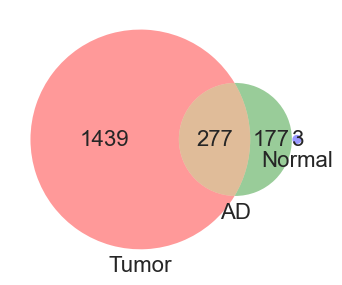

In [13]:
plt.figure(figsize=(4,4))
venn = venn3([tumor_set, ad_set, normal_set], set_labels=('Tumor', 'AD', 'Normal'))

for circle in venn.set_labels:
    circle.set_size(16)
for label in venn.subset_labels:
    if label:
        label.set_fontsize(16)
plt.show()

In [14]:
spcific = pd.DataFrame((ad_set - tumor_set))

In [15]:
genedict = dict(zip(snv.var['gene_ids'],snv.var['gene_name']))
funcdict = dict(zip(snv.var['gene_ids'],snv.var['Func_L0']))
spcific['gene'] = spcific[0].map(genedict)
spcific['func'] = spcific[0].map(funcdict)

In [16]:
spcific['genemo'] = spcific['gene'].apply(lambda x : x.split(';')[0])

# specfic

In [17]:
pair_snvlfc['func'] = pair_snvlfc['Adjacent_n'].map(dict(zip(snv.var['gene_ids'],snv.var['Func_L0'])))
pair_snvlfc['gene'] = pair_snvlfc['Adjacent_n'].map(dict(zip(snv.var['gene_ids'],snv.var['gene_name'])))
gene_dict = dict(zip(rnalfc['Adjacent_n'],rnalfc['Adjacent_l']))
gene_p_dict = dict(zip(rnalfc['Adjacent_n'],rnalfc['Adjacent_p']))

pair_snvlfc['rna_l'] = pair_snvlfc['gene'].apply(lambda x : [ gene_dict.get(i) for i in x.split(';')])
pair_snvlfc['rna_p'] = pair_snvlfc['gene'].apply(lambda x : [ gene_p_dict.get(i) for i in x.split(';')])
snvlfc = pair_snvlfc[pair_snvlfc['rna_l'].map(len)==1].copy()
snvlfc['rna_l'] = snvlfc['rna_l'].map(lambda x: x[0])
snvlfc['rna_p'] = snvlfc['rna_p'].map(lambda x: x[0])

In [18]:
adsnvlfc = snvlfc[['Adjacent_n','Adjacent_l','func','Adjacent_p']]
adsnvlfc = adsnvlfc[adsnvlfc['Adjacent_p']<0.05]

In [19]:
snvannodict = dict(zip(snv.var_names,snv.var['gene_name']))
adsnvlfc['gene'] = adsnvlfc['Adjacent_n'].map(snvannodict)

In [20]:
adsnvlfc[:30]

,Adjacent_n,Adjacent_l,func,Adjacent_p,gene
0,chr17_50184327:A>C,3.069441,UTR,2.225511e-91,COL1A1
1,chr7_94430617:C>T,3.396282,UTR,1.915196e-47,COL1A2
2,chr20_4024544:C>T,0.955810,Intergenic,1.028996e-42,FTLP3
3,chr22_22901316:A>C,2.981575,UTR,3.578190e-41,IGLC2
4,chr12_91103708:A>G,2.769517,UTR,6.462271e-39,LUM
5,chr20_4024581:C>T,0.933191,Intergenic,1.319221e-29,FTLP3
6,chr7_94430597:A>C,3.483626,UTR,2.688846e-27,COL1A2
7,chr20_4024281:T>C,1.072072,Exonic,1.734072e-26,FTLP3
8,chr20_4024269:A>G,1.054436,Exonic,1.517465e-22,FTLP3
11,chr5_151661589:G>C,1.672346,UTR,8.389655e-14,SPARC


# SupFigure6

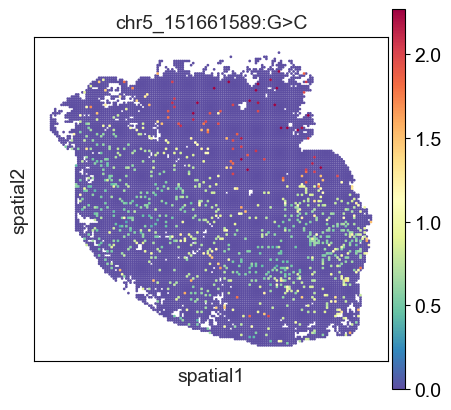

In [21]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = ['chr5_151661589:G>C'],basis = 'spatial',spot_size = 130,show = False,ax = ax,vmax = 'p99.9',cmap = 'Spectral_r')
fig.show()

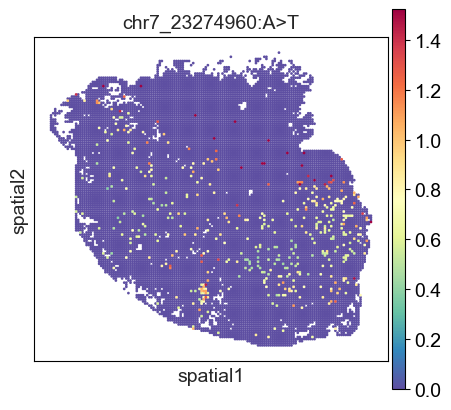

In [22]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = ['chr7_23274960:A>T'],basis = 'spatial',spot_size = 130,show = False,ax = ax,vmax = 'p99.9',cmap = 'Spectral_r')
fig.show()

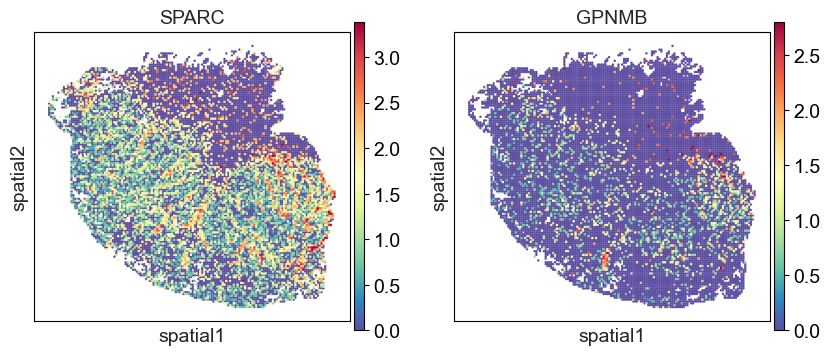

In [23]:
sc.pl.spatial(rna,color = ['SPARC','GPNMB'],basis = 'spatial',spot_size = 130,vmax = 'p99.9',cmap = 'Spectral_r')

In [24]:
total_list = []
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'UTR'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'Exonic'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'Intronic'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())
total_list.extend(adsnvlfc[adsnvlfc['func'] == 'Intergenic'].sort_values('Adjacent_l',ascending=False)[:3]['Adjacent_n'].tolist())

In [25]:
total_list = adsnvlfc[:15]['Adjacent_n'].tolist()

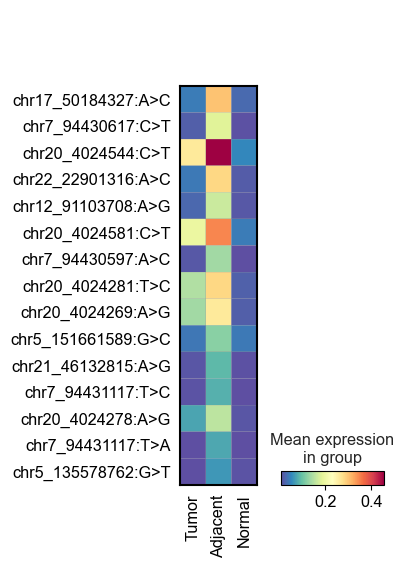

In [26]:
sc.pl.matrixplot(snv,total_list,groupby = 'cluster',cmap = 'Spectral_r',swap_axes = True)

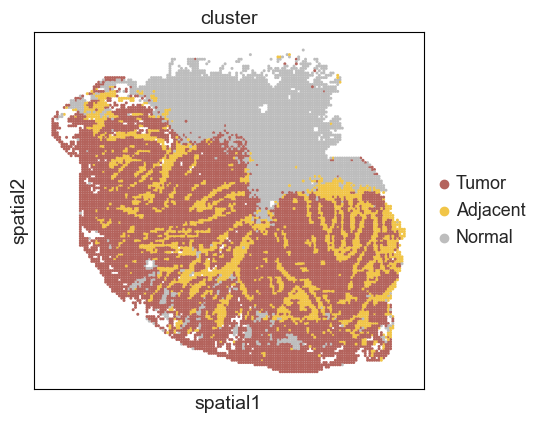

In [27]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = 'cluster',basis = 'spatial',spot_size = 130,show = False,ax = ax)
fig.show()

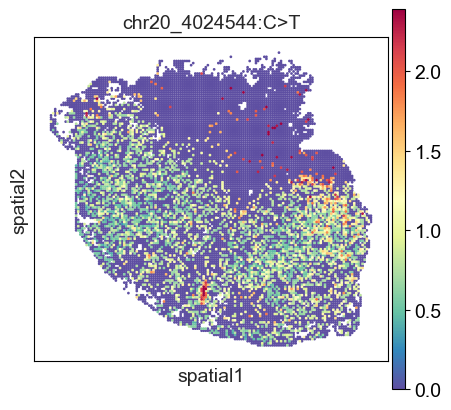

In [28]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = ['chr20_4024544:C>T'],basis = 'spatial',spot_size = 130,show = False,ax = ax,vmax = 'p99.9',cmap = 'Spectral_r')
fig.show()

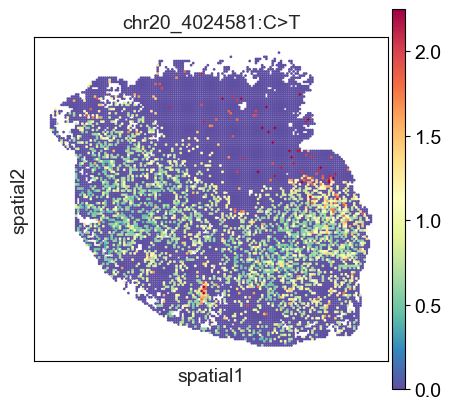

In [29]:
fig,ax = plt.subplots(figsize = (5,5))
sc.pl.spatial(snv,color = ['chr20_4024581:C>T'],basis = 'spatial',spot_size = 130,show = False,ax = ax,vmax = 'p99.9',cmap = 'Spectral_r')
fig.show()

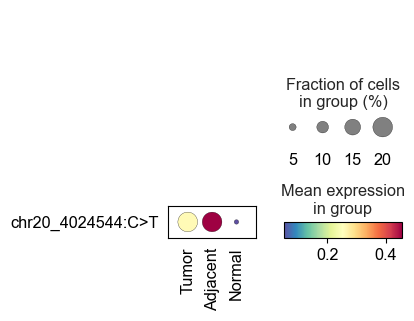

In [30]:
fig,ax = plt.subplots(figsize = (3,3))
sc.pl.dotplot(snv,'chr20_4024544:C>T',groupby = 'cluster',cmap = 'Spectral_r',swap_axes=True,dot_max = 0.2,show = False,ax = ax)
fig.show()

In [31]:
tmp = snv.obs['cluster'].reset_index()
tmp['x'] = tmp['index'].apply(lambda x : x.split('_')[1]) 
tmp['y'] = tmp['index'].apply(lambda x : x.split('_')[2]) 
tmp = tmp.rename({'cluster':'RNA_cluster'},axis = 1)
# tmp.to_csv('CRC-P59-T_1_cluster.csv')

# gsva

In [32]:
gsvadf = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure2/CRC-P59-T_1.gsva.csv',index_col = 0).T

In [33]:
gsva = AnnData(gsvadf)

gsva = gsva[gsva.obs_names.isin(rna.obs_names)][rna.obs_names].copy()

gsva.obs['cluster'] = rna.obs['cluster']
gsva.obsm['spatial'] = rna.obsm['spatial']

sc.pp.scale(gsva,max_value=10)

sc.tl.rank_genes_groups(gsva, "cluster",groups=["Adjacent"], reference="Tumor", method="wilcoxon")

result = gsva.uns["rank_genes_groups"]
groups = result["names"].dtype.names
gsvalfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals",'logfoldchanges']
    }
)

data  = gsvalfc

/home/liuyi/miniconda3/envs/spatialsnv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [34]:
def plot_density(df, palette=None, groupby='cluster', key='ros',save = None):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    if palette is None:
        palette = sns.color_palette("Set3", n_colors=df[groupby].nunique())
    g = sns.FacetGrid(df, row=groupby, hue=groupby, aspect=5, height= 1, palette=palette)
    g.map(sns.kdeplot, key, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, key, clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    def add_median_line(data, **kwargs):
        median_val = data.median()
        plt.axvline(median_val, color='black', linestyle='--', linewidth=1,ymax = 0.2)
        g.map(add_median_line, key)
    
    def label(data, color, label, **kwargs):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

    g.map(label, key)
    
    g.figure.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    if save != None:
        g.savefig(save, bbox_inches='tight')
    plt.show()

In [35]:
gsva.obs['ir'] = np.sum(gsva[:,gsva.var_names == "HALLMARK_INFLAMMATORY_RESPONSE"].X,axis =1)
gsva.obs['my'] = np.sum(gsva[:,gsva.var_names == "HALLMARK_HYPOXIA"].X,axis =1)
palette = {'Tumor': '#C15E58', 'Adjacent': '#FAC319', 'Normal': '#BDBDBD'}
mydf = pd.DataFrame({'my': gsva.obs['my'], 'cluster': gsva.obs['cluster']})
irdf = pd.DataFrame({'ir': gsva.obs['ir'], 'cluster': gsva.obs['cluster']})

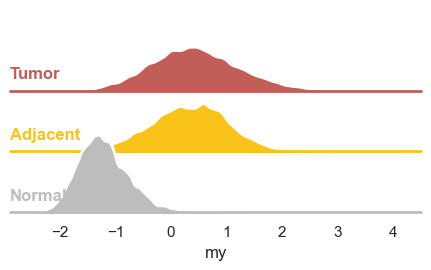

In [36]:
plot_density(mydf,groupby='cluster', key = 'my',palette=palette)#,save = "./MainFigure/Fig3G.hypoxia.pdf")

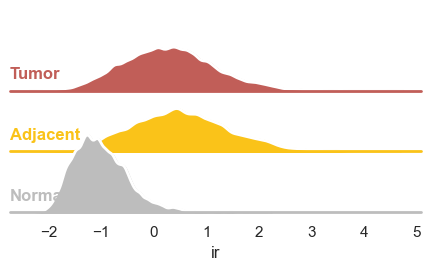

In [37]:
plot_density(irdf,groupby='cluster', key = 'ir',palette=palette)#,save = "./MainFigure/Fig3G.INFLAMMATORY_RESPONSE.pdf")

In [38]:
gsva.obs['snvperumi'] = snv.obs['snvperumi']

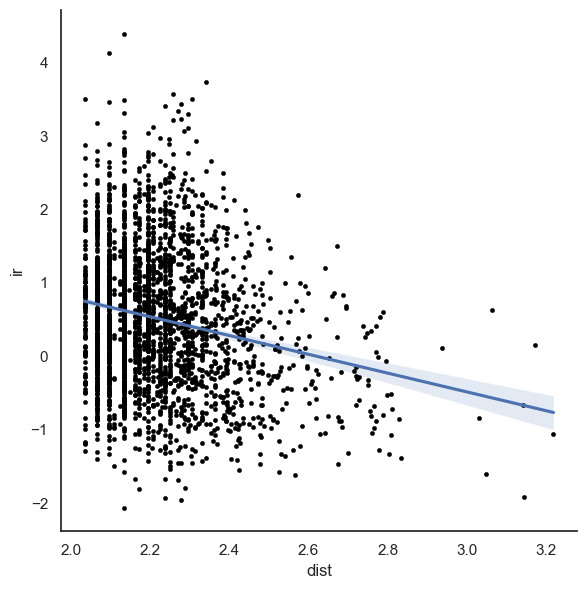

In [39]:
tree = KDTree(gsva.obsm['spatial'][gsva.obs['cluster']=='Tumor',:])
query = tree.query(gsva.obsm['spatial'][gsva.obs['cluster']=='Adjacent',:], k = 5)
count = gsva.obs.loc[gsva.obs['cluster']=='Adjacent',['ir']]
count['dist']= query[0].mean(axis=1)
count['dist'] = np.log10(count['dist'])
g = sns.lmplot(data=count, x='dist', y='ir',height=6,scatter_kws = {'s': 0})
for ax in g.axes.flatten():
    sns.scatterplot(data = count, x= 'dist',y = 'ir',color = 'black',s= 10,edgecolor = None,ax =ax)
ax.grid(False)
plt.show()

In [40]:
corr, p_value = spearmanr(count['dist'], count['ir'])
print(corr,p_value)

-0.15089727289885274 1.3676768418118969e-15


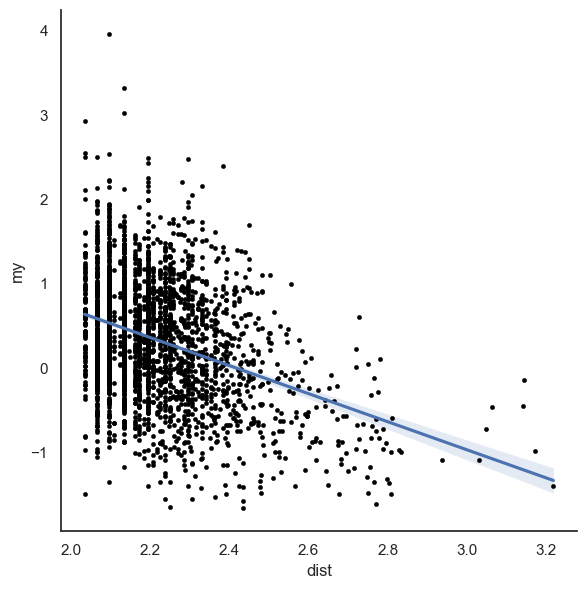

In [41]:
tree = KDTree(gsva.obsm['spatial'][gsva.obs['cluster']=='Tumor',:])
query = tree.query(gsva.obsm['spatial'][gsva.obs['cluster']=='Adjacent',:], k = 5)
count = gsva.obs.loc[gsva.obs['cluster']=='Adjacent',['my']]
count['dist']= query[0].mean(axis=1)

count['dist'] = np.log10(count['dist'])
g = sns.lmplot(data=count, x='dist', y='my',height=6,scatter_kws = {'s': 0})
for ax in g.axes.flatten():
    sns.scatterplot(data = count, x= 'dist',y = 'my',color = 'black',s= 10,edgecolor = None,ax =ax)
ax.grid(False)
plt.show()

In [42]:
corr, p_value = spearmanr(count['dist'], count['my'])
print(corr,p_value)

-0.27183401549437064 3.571977491877787e-48


In [43]:
color_dict = {
    'CRC-P19-T':'#D99590',"CRC-P59-T_1":"#E69F8F","CRC-P59-T_2":"#EFBA9C","CRC-P67-T":"#F6E3C3","LC05-M_DU3":'#89A6CD',"LC05-T_FD3":'#C1A0C7'
}

>>CRC-P19-T
-0.5468293294547709 0.524724461434573
>>CRC-P59-T_1
-0.5912228424484814 0.2755501869289957
>>CRC-P59-T_2
-0.15905549113535722 0.22703798128333402
>>CRC-P67-T
-0.31519595645811804 0.2905972005713286
>>LC05-M_DU3
-0.13910651568561416 0.3620384162258737
>>LC05-T_FD3
-0.07120737392093707 0.019213985628953493


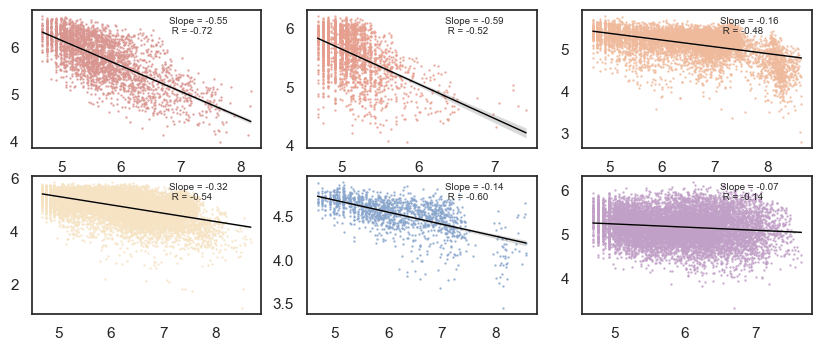

In [44]:
slope_list = []
fig,axs = plt.subplots(2,3,figsize = (10,4),sharex=False,sharey=False)
m = 0
for sample in ['CRC-P19-T', 'CRC-P59-T_1', 'CRC-P59-T_2', 'CRC-P67-T', 'LC05-M_DU3','LC05-T_FD3']:
    ax = axs[m//3][m%3]
    m += 1
    print(f'>>{sample}')
    rna = sc.read_h5ad(f'{root_path}/rna_adata/{sample}.rna.h5ad')
    snv = sc.read_h5ad(f'{root_path}/snv_adata/{sample}.snv.h5ad')
    snv.obs['cluster'] = rna.obs['cluster']
    snv.X = snv.layers['norm']
    tree = KDTree(snv.obsm['spatial'][snv.obs['cluster']=='Tumor',:])
    query = tree.query(snv.obsm['spatial'][snv.obs['cluster']=='Adjacent',:], k = 5)
    count = snv.obs.loc[snv.obs['cluster']=='Adjacent',['snvperumi']]
    count['dist']= query[0].mean(axis=1)
    count['logdist'] = np.log(count['dist'])
    count['logsnv'] = np.log(count['snvperumi'])
    if sample in ['CRC-P19-T', 'CRC-P59-T_1', 'CRC-P59-T_2', 'CRC-P67-T']:
        color = '#EFAE95'
    else:
        color = "#74A8CE"
    color = color_dict[sample]
    p = sns.regplot(data = count,x= 'logdist' ,y = 'logsnv',color = color,scatter_kws = {'s':0.5,"rasterized":True},ax =ax,line_kws={'color': 'black', 'linewidth': 1},)
    tslope, tintercept, tr_value, tp_value, tstd_err = scipy.stats.linregress(x = count['logdist'],y = count['logsnv'])
    print(tslope,tr_value*tr_value)
    equation_text = f'Slope = {tslope:.2f}\n R = {tr_value:.2f}'
    ax.text(0.6, 0.95, equation_text, transform=ax.transAxes, fontsize=7, verticalalignment='top')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    slope_list.append([sample,tslope])
plt.show()

In [45]:
slopedf = pd.DataFrame(slope_list,columns = ['sample','slope']).set_index('sample')

In [46]:
gsva = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure4/combine.gsva.csv',index_col = 0).T
estimate = pd.read_csv(f'{root_path}/otherdata_for_figure/Figure4/combine.estimate.csv',index_col = 0).T

In [47]:
slopedf['ESTIMATEScore'] = estimate['ESTIMATEScore']
slopedf['color'] = ['#D99590','#E69F8F','#EFBA9C','#F6E3C3','#89A6CD','#C1A0C7']

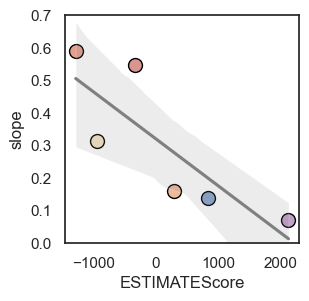

In [48]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(3, 3))

for idx,sample in enumerate(slopedf.index):
    tmp = slopedf.loc[sample]
    # ax.scatter(y=np.abs(slopedf['slope']), x=slopedf['ESTIMATEScore'], color=slopedf['color'], s=100, ax=ax,edgecolor = 'black',legend=True)
    ax.scatter(y = np.abs(tmp['slope']),x = tmp['ESTIMATEScore'],color = tmp['color'],s = 100,edgecolor = 'black',label = sample)
sns.regplot(y=np.abs(slopedf['slope']), x=slopedf['ESTIMATEScore'], color = 'grey',scatter=False, ax=ax)
ax.set_ylim(0,0.7)
ax.grid(False)
plt.show()